In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
import numpy as np
import xgboost as xgb
import sklearn
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import geopandas as gpd


In [2]:
df = pd.read_excel('Data paper geothermal fixx.xlsx')
df

,Name,X,Y,Temp,pH,Na,K,B,Cl,SiO2,Ec
0,CBN3,761872,9.206546e+06,21,6.10,3.8,1.4,0.0,7.3,4.0,110
1,CBN2,762551,9.206354e+06,46,2.80,0.0,1.6,0.1,40.7,4.0,780
2,CBN1,762590,9.206602e+06,90,2.50,0.0,2.0,0.3,40.6,9.0,1750
3,WLN5,762930,9.210113e+06,46,6.10,75.8,23.9,0.0,150.4,16.3,1270
4,WLN4,763121,9.210218e+06,45,6.20,51.3,20.4,2.4,83.7,13.0,1180
5,WLN3,763191,9.210013e+06,21,6.30,14.2,5.0,0.6,17.7,4.0,330
6,WLN2,763269,9.209774e+06,43,6.20,52.9,20.8,3.4,120.4,12.0,1350
7,WLN1,763513,9.209522e+06,44,6.10,53.4,20.8,3.9,113.6,13.0,1300
8,CMG2,764161,9.208995e+06,71,6.40,91.0,18.3,0.0,42.7,56.1,460
9,CMG,764331,9.209147e+06,49,6.10,65.2,18.1,1.4,21.3,16.0,810


<Axes: >

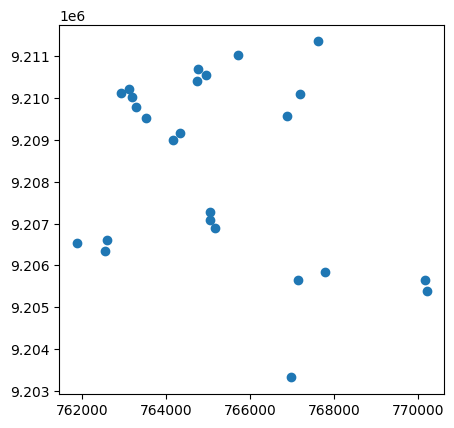

In [4]:
from shapely.geometry import Point
import contextily as ctx

geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

gdf.plot()

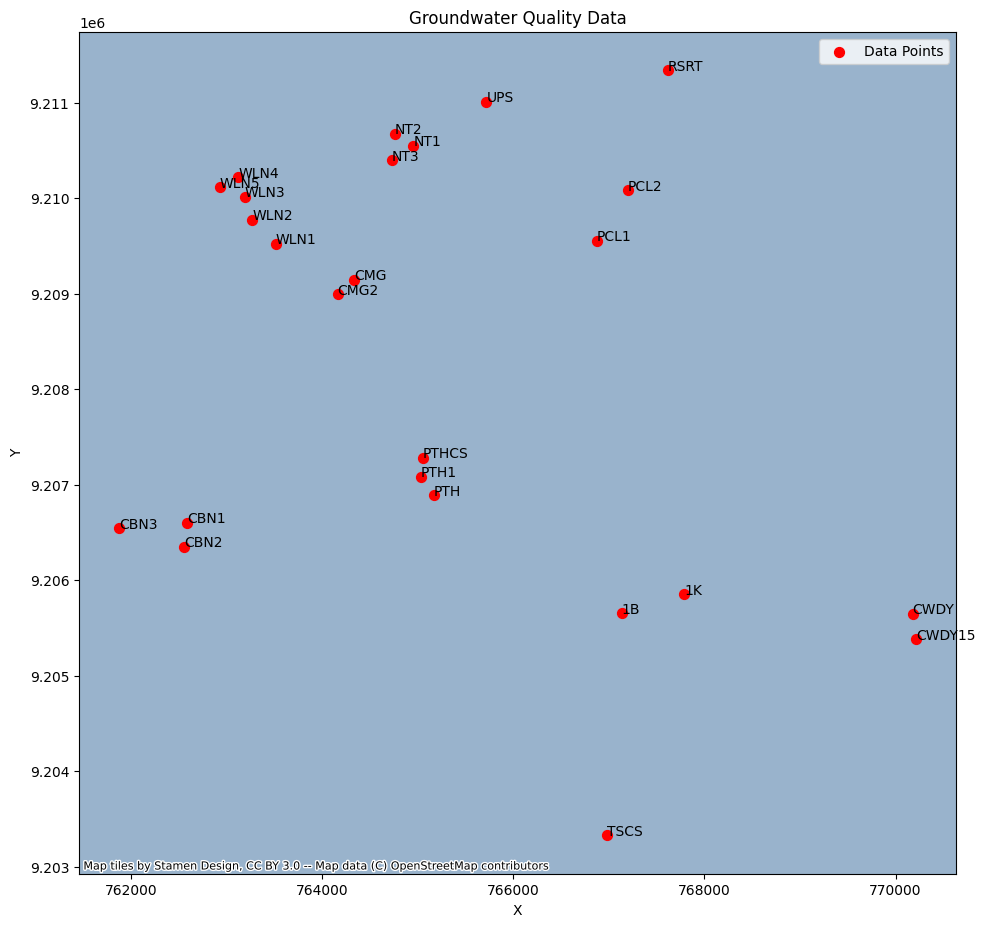

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Data Points')

ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, zoom=12)

for _, row in gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row['Name'], fontsize=10, color='black')

plt.title("Groundwater Quality Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
df.describe()

,X,Y,Temp,pH,Na,K,B,Cl,SiO2,Ec
count,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,765237.080000,9.208321e+06,47.200000,5.222000,53.168000,16.780000,4.040000,531.332000,18.312000,1876.960000
std,2270.604947,2.222871e+03,21.859399,1.924223,53.146188,16.089463,6.935717,1443.311577,22.328631,3862.590382
min,761872.000000,9.203330e+06,15.000000,0.500000,0.000000,0.500000,0.000000,0.100000,0.000000,42.000000
25%,763269.000000,9.206546e+06,35.000000,3.700000,6.900000,2.000000,0.000000,7.300000,7.000000,360.000000
50%,764953.000000,9.209147e+06,44.000000,6.100000,37.900000,18.100000,0.600000,83.700000,13.000000,1180.000000
75%,766976.000000,9.210113e+06,51.000000,6.200000,91.000000,20.800000,7.800000,311.700000,19.000000,1930.000000
max,770213.000000,9.211340e+06,91.000000,7.800000,151.000000,50.200000,31.900000,6342.000000,108.000000,20000.000000


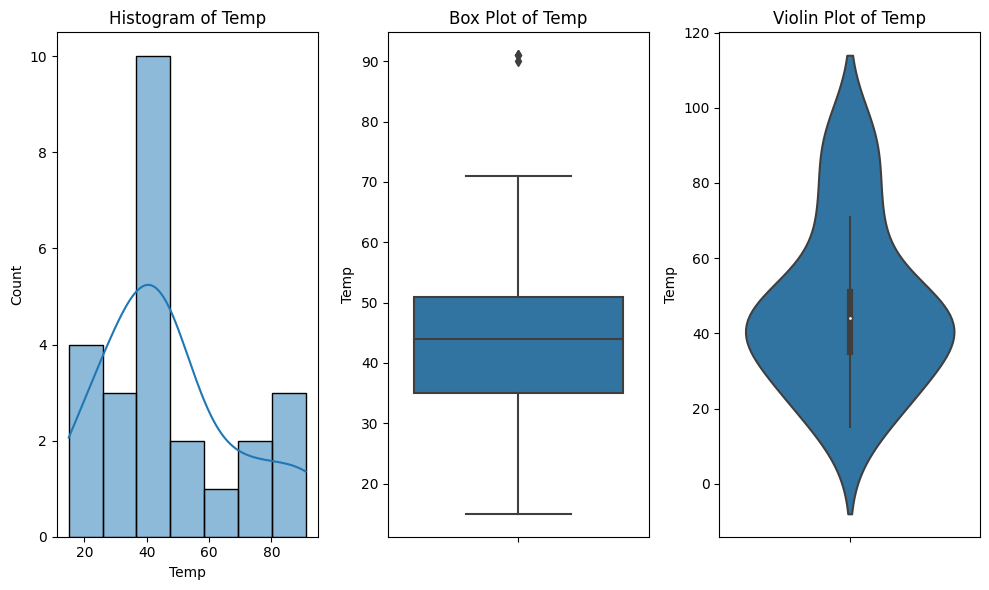

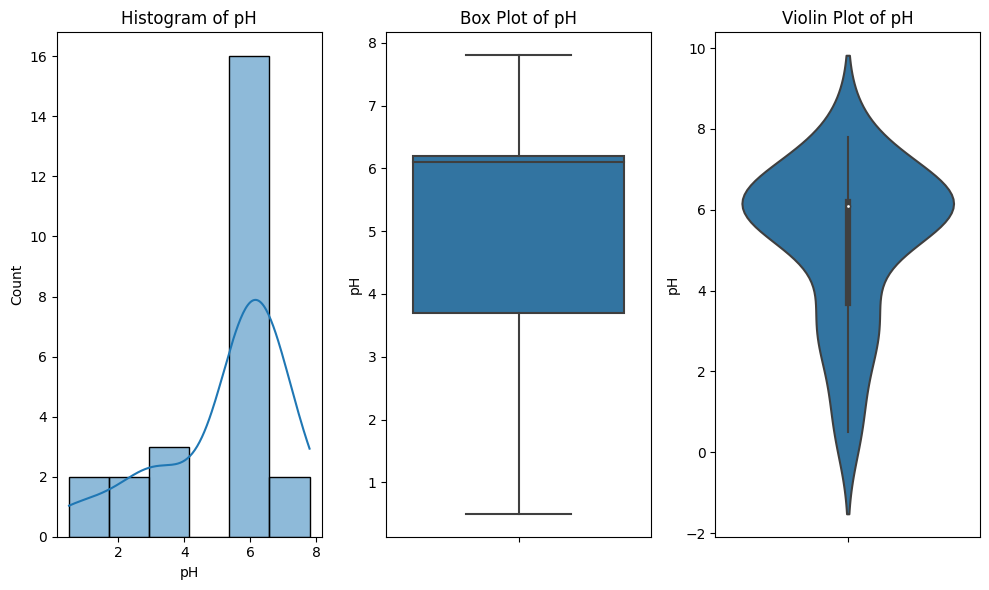

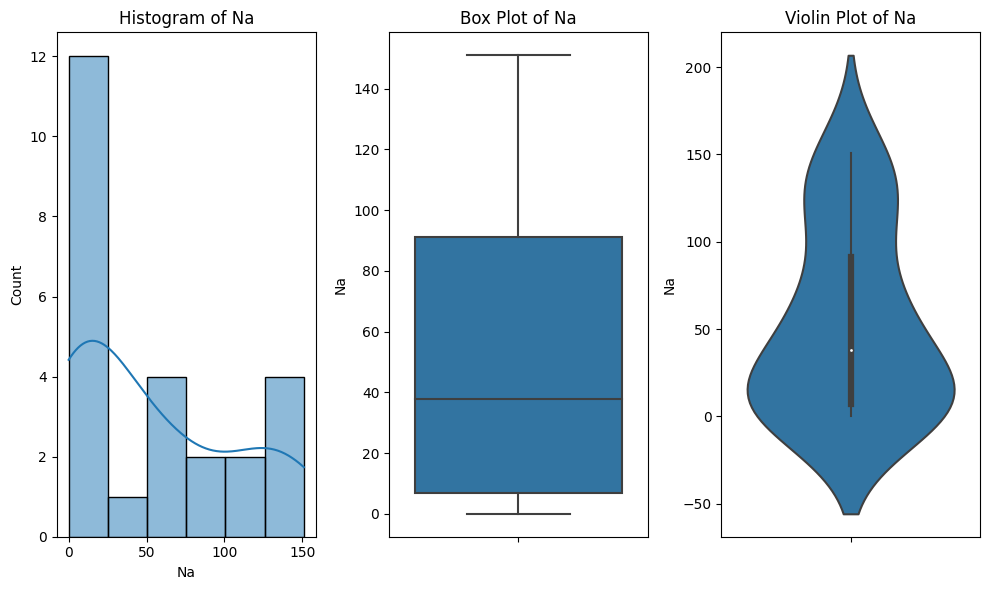

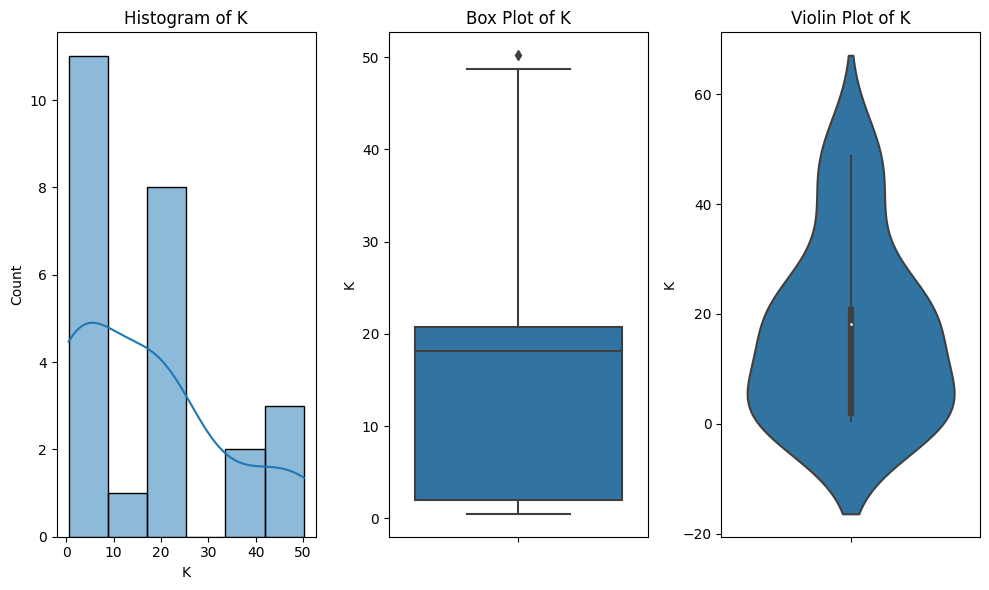

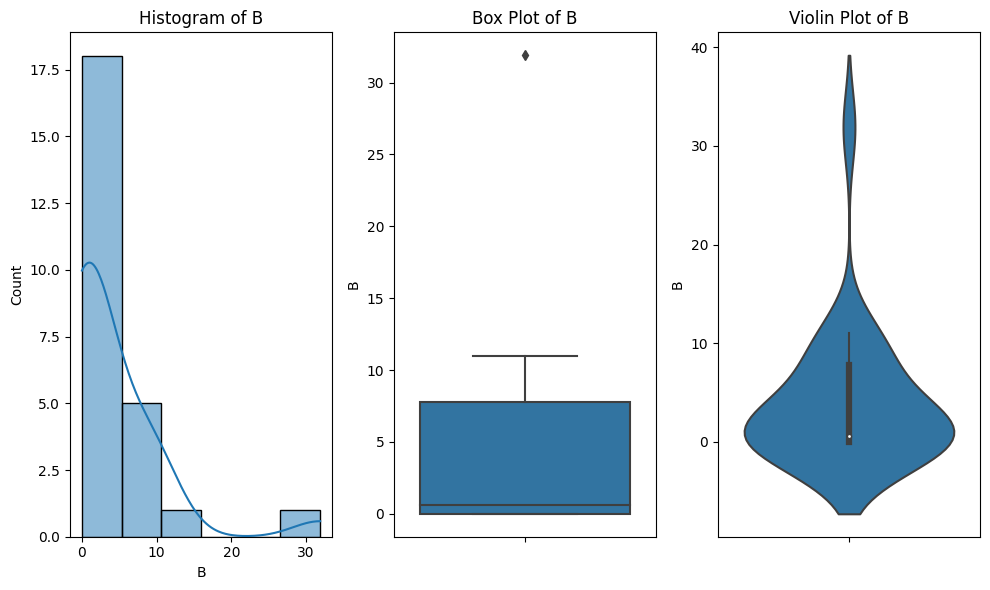

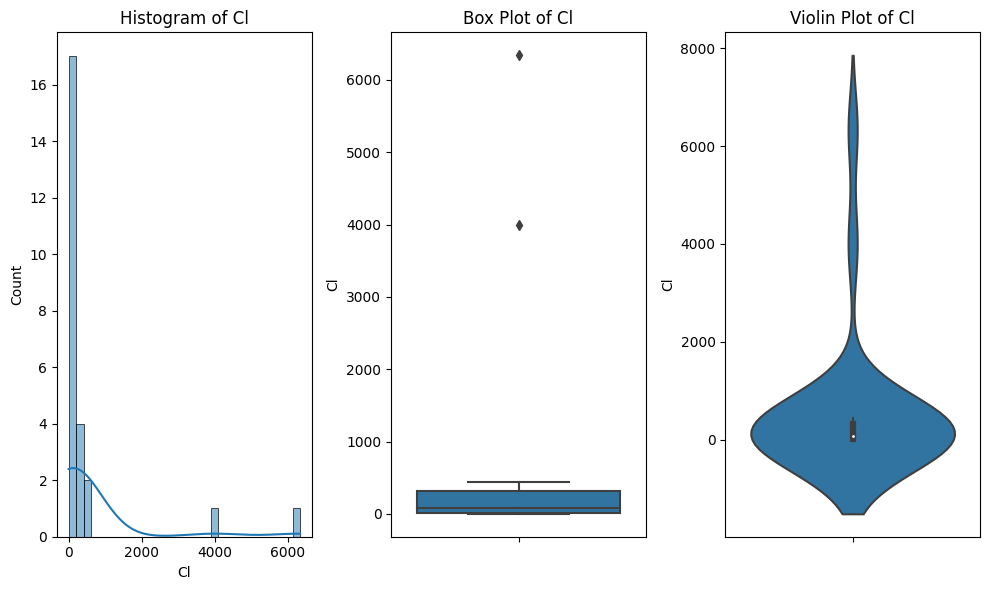

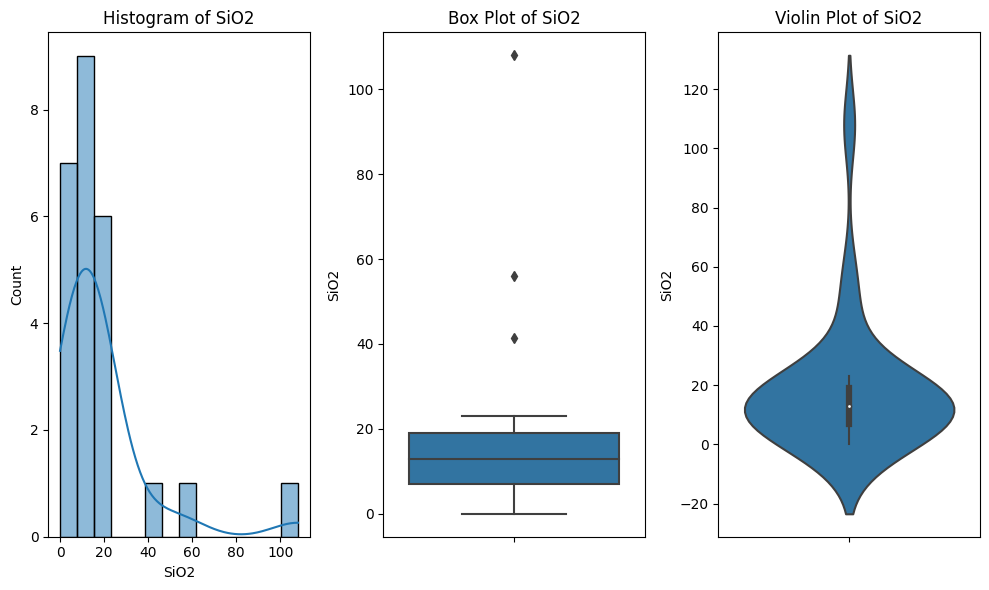

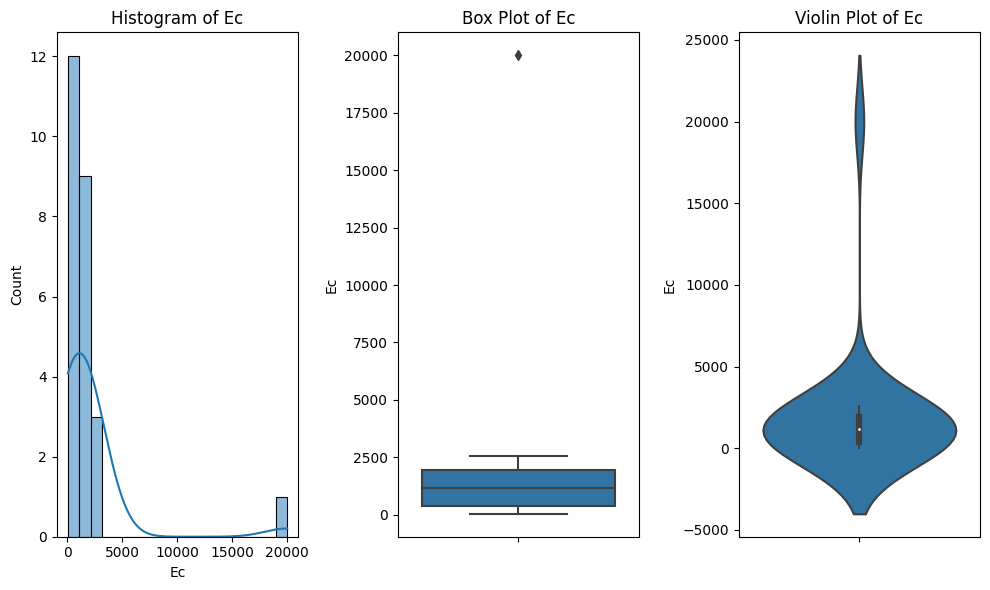

In [10]:
parameters = ['Temp', 'pH', 'Na', 'K', 'B', 'Cl', 'SiO2', 'Ec']

for parameter in parameters:
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1)
    sns.histplot(data=gdf, x=parameter, kde=True)
    plt.title(f'Histogram of {parameter}')
    
    # Box plot
    plt.subplot(1, 3, 2)
    sns.boxplot(data=gdf, y=parameter)
    plt.title(f'Box Plot of {parameter}')
    
    # Violin plot
    plt.subplot(1, 3, 3)
    sns.violinplot(data=gdf, y=parameter)
    plt.title(f'Violin Plot of {parameter}')
    
    plt.tight_layout()
    plt.show()

In [14]:
for parameter in parameters:
    df[parameter + '_log'] = np.log(df[parameter] + 1)

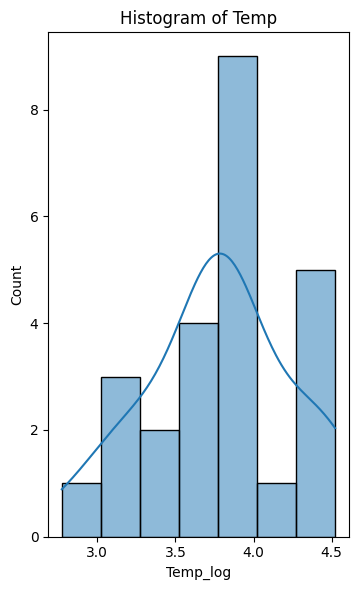

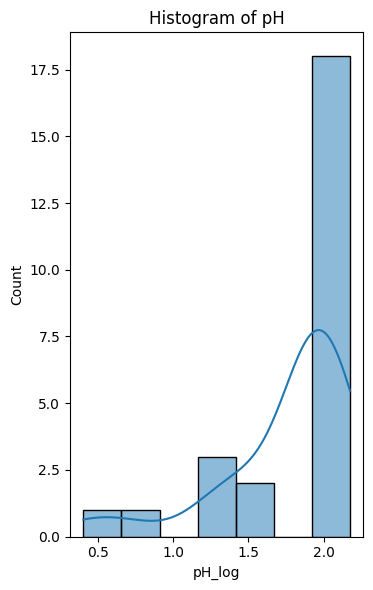

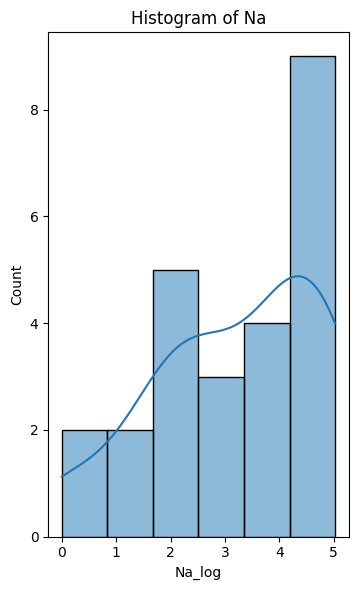

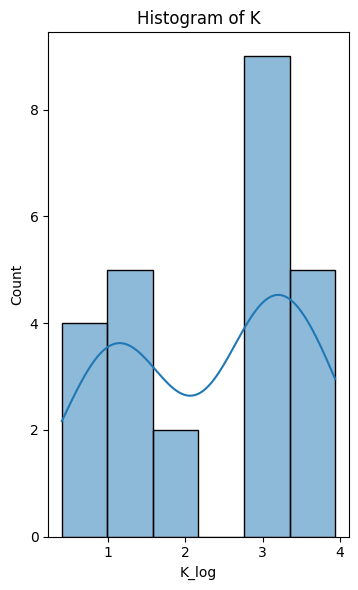

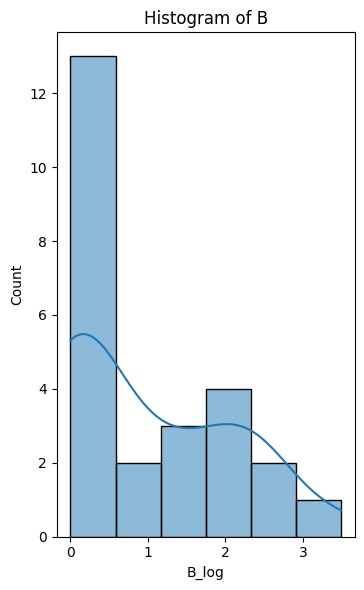

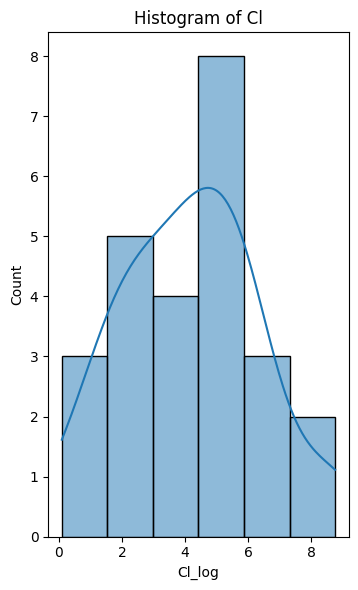

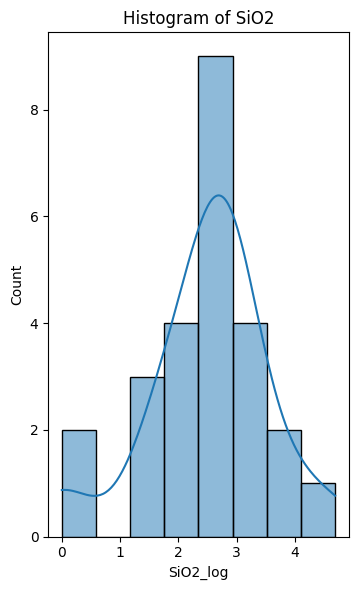

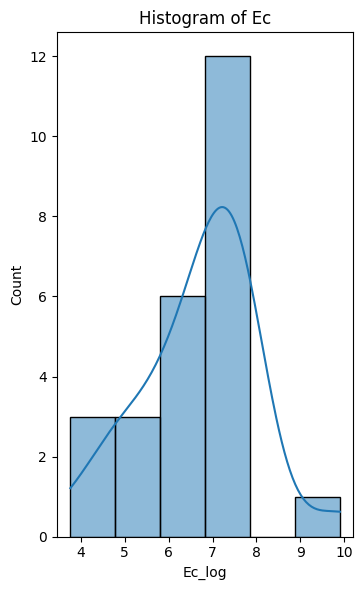

In [15]:
for parameter in parameters:
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=parameter + '_log', kde=True)
    plt.title(f'Histogram of {parameter}')
    
    plt.tight_layout()
    plt.show()

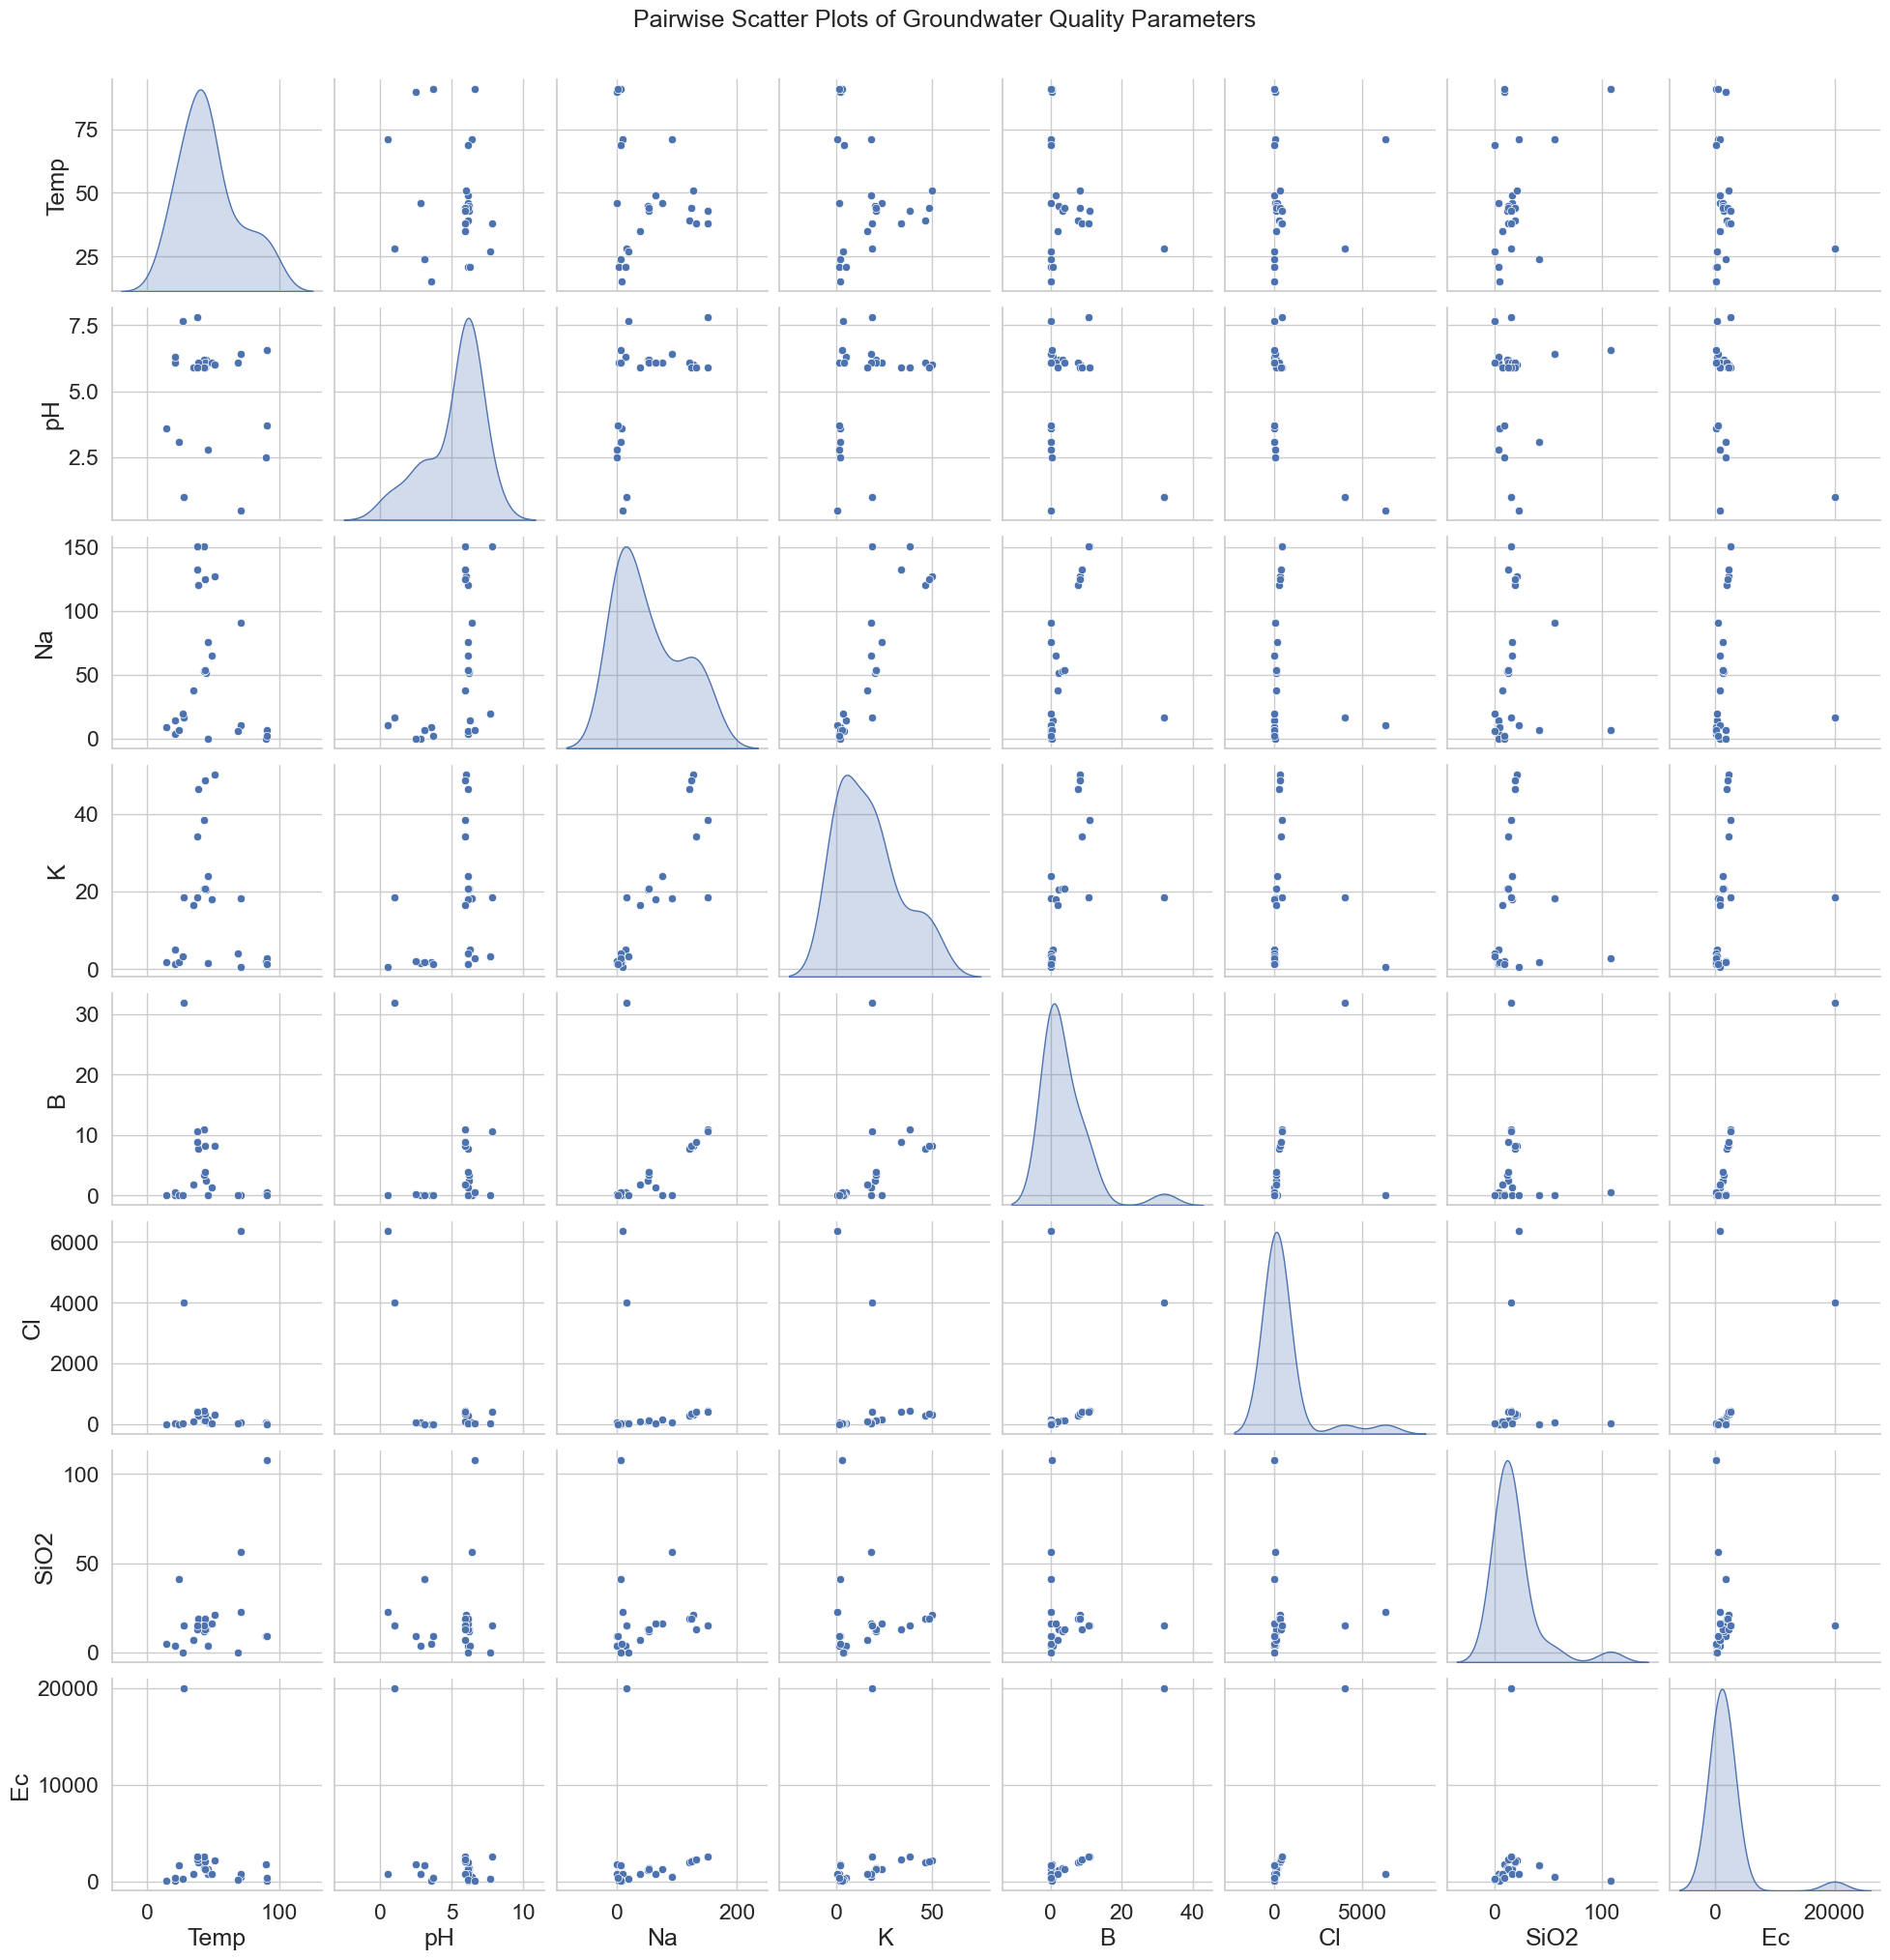

In [18]:
sns.set(style="whitegrid", font_scale=1.5)
sns.pairplot(df[parameters], diag_kind='kde')
plt.suptitle('Pairwise Scatter Plots of Groundwater Quality Parameters', y=1.02, fontsize=18)
plt.show()

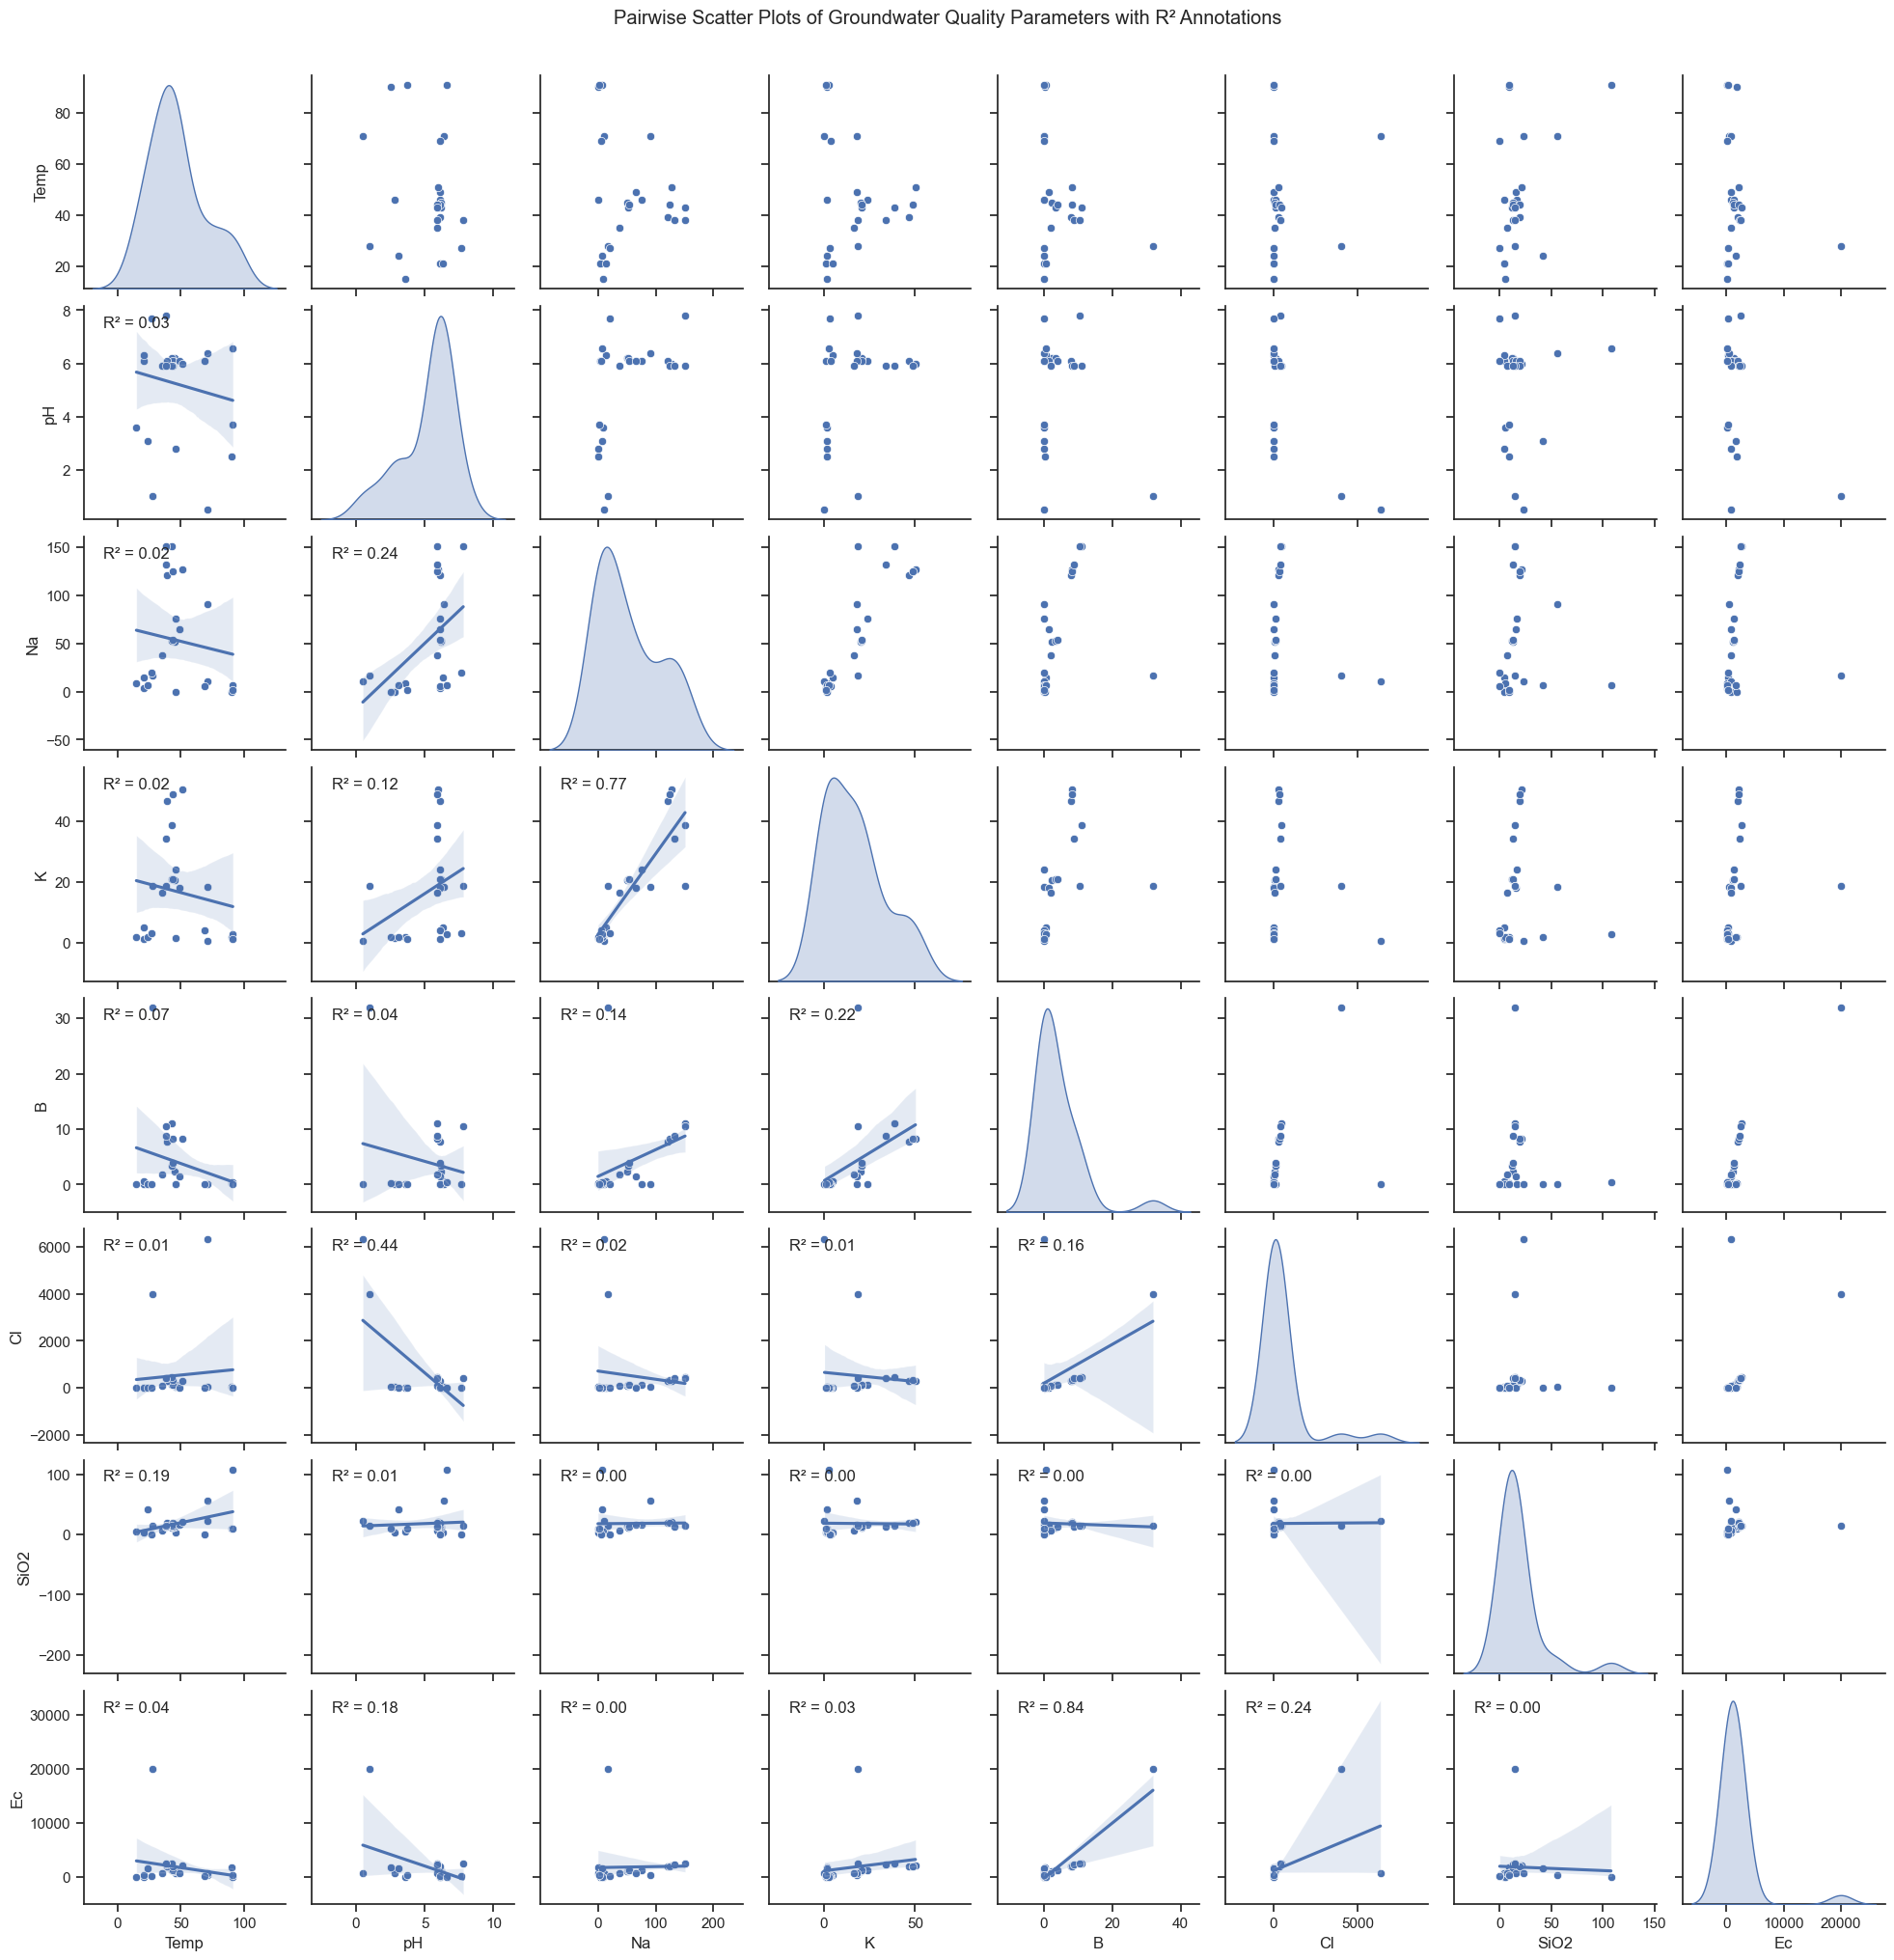

In [21]:
from scipy.stats import linregress

# Create scatter plots to explore pairwise correlations with r-squared annotations
sns.set(style="ticks")
g = sns.pairplot(df[parameters], diag_kind='kde')

# Add linear regression lines and r-squared annotations
for i, parameter1 in enumerate(parameters):
    for j, parameter2 in enumerate(parameters):
        if i < j:
            ax = g.axes[j, i]
            sns.regplot(x=parameter1, y=parameter2, data=df, ax=ax, scatter=False)
            
            # Calculate and annotate r-squared value
            slope, intercept, r_value, p_value, std_err = linregress(df[parameter1], df[parameter2])
            r_squared = r_value ** 2
            ax.text(0.1, 0.9, f"R² = {r_squared:.2f}", transform=ax.transAxes)
        
plt.suptitle("Pairwise Scatter Plots of Groundwater Quality Parameters with R² Annotations", y=1.02)
plt.show()

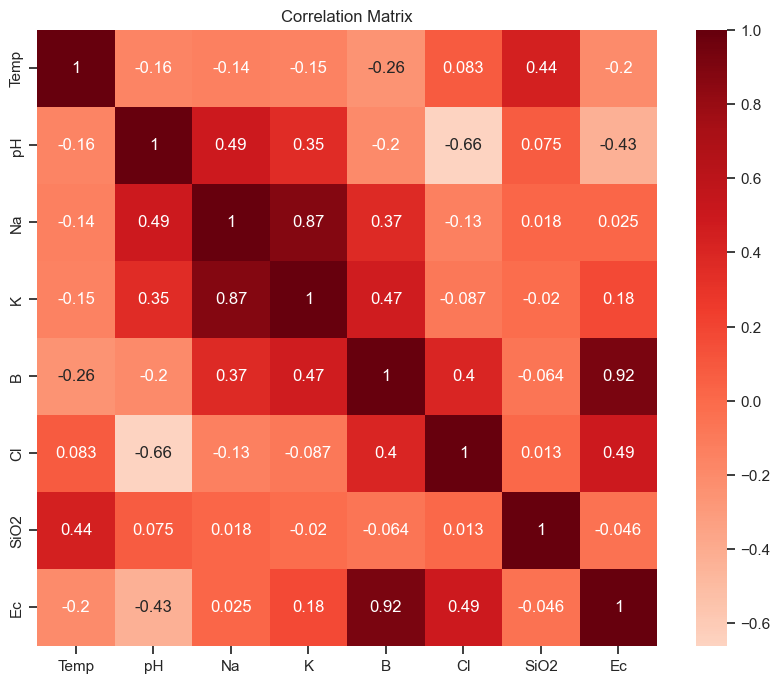

In [22]:
correlation_matrix = df[parameters].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds, center=0)
plt.title('Correlation Matrix')
plt.show()

In [23]:
correlation_matrix

,Temp,pH,Na,K,B,Cl,SiO2,Ec
Temp,1.000000,-0.158683,-0.135383,-0.152056,-0.255589,0.082728,0.436594,-0.200493
pH,-0.158683,1.000000,0.491689,0.351338,-0.197508,-0.660578,0.074982,-0.428166
Na,-0.135383,0.491689,1.000000,0.874990,0.370073,-0.128934,0.018327,0.024635
K,-0.152056,0.351338,0.874990,1.000000,0.468761,-0.086863,-0.019835,0.176100
B,-0.255589,-0.197508,0.370073,0.468761,1.000000,0.396940,-0.064172,0.915991
Cl,0.082728,-0.660578,-0.128934,-0.086863,0.396940,1.000000,0.013366,0.488658
SiO2,0.436594,0.074982,0.018327,-0.019835,-0.064172,0.013366,1.000000,-0.045875
Ec,-0.200493,-0.428166,0.024635,0.176100,0.915991,0.488658,-0.045875,1.000000


In [27]:
from scipy.interpolate import griddata

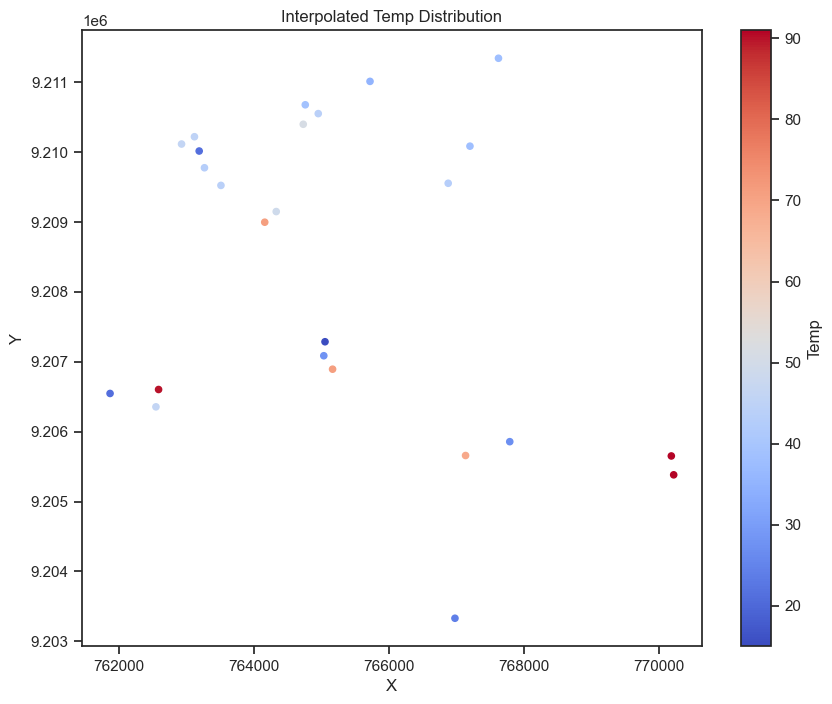

In [28]:
# Define the grid for interpolation
grid_x, grid_y = np.meshgrid(np.linspace(df['X'].min(), df['X'].max(), 100),
                             np.linspace(df['Y'].min(), df['Y'].max(), 100))

# Specify the groundwater quality parameter to interpolate
parameter_to_interpolate = 'Temp'

# Perform interpolation using griddata
interpolated_values = griddata((df['X'], df['Y']), df[parameter_to_interpolate],
                               (grid_x, grid_y), method='linear')

# Plot the interpolated values on a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(df['X'], df['Y'], c=df[parameter_to_interpolate], cmap='coolwarm', s=20)
plt.colorbar(label=parameter_to_interpolate)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Interpolated {parameter_to_interpolate} Distribution')
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [34]:
selected_features = ['Na', 'Cl', 'Ec', 'Temp', 'K', 'B', 'SiO2']  # Adjust based on your selections

# Split data into input features (X) and target variable (y)
X = df[selected_features]
y = df['pH']  # Replace with the actual target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 23.964219277729566


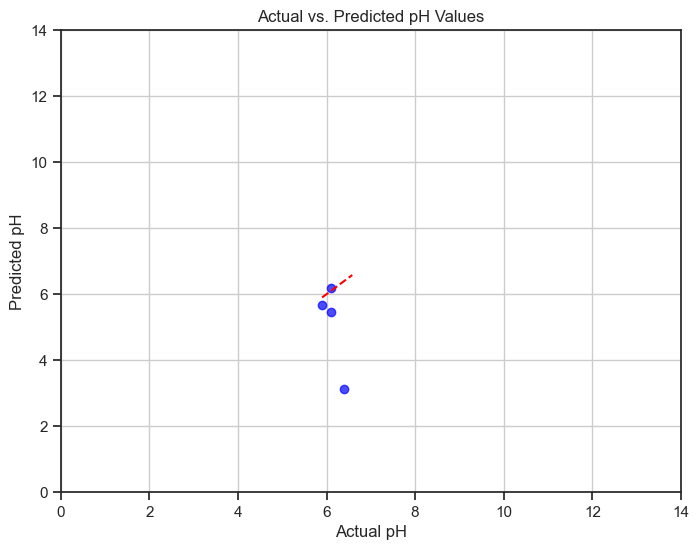

In [40]:
# Plot actual vs. predicted pH values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted pH Values')
plt.xlabel('Actual pH')
plt.ylabel('Predicted pH')
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.grid(True)
plt.show()

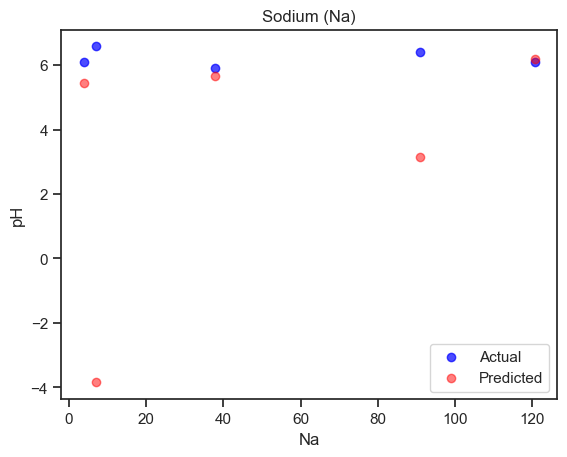

In [39]:
plt.subplot()
plt.scatter(X_test['Na'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['Na'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Sodium (Na)')
plt.xlabel('Na')
plt.ylabel('pH')
plt.legend()

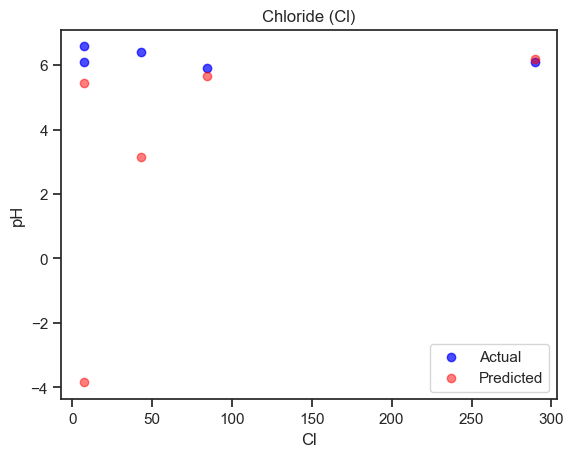

In [41]:
plt.subplot()
plt.scatter(X_test['Cl'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['Cl'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Chloride (Cl)')
plt.xlabel('Cl')
plt.ylabel('pH')
plt.legend()

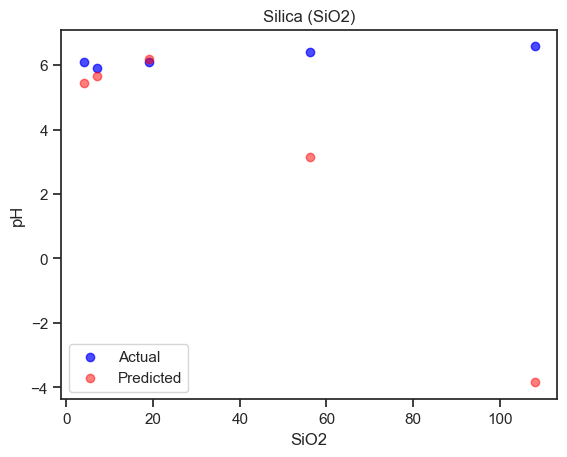

In [43]:
plt.subplot()
plt.scatter(X_test['SiO2'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['SiO2'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Silica (SiO2)')
plt.xlabel('SiO2')
plt.ylabel('pH')
plt.legend()

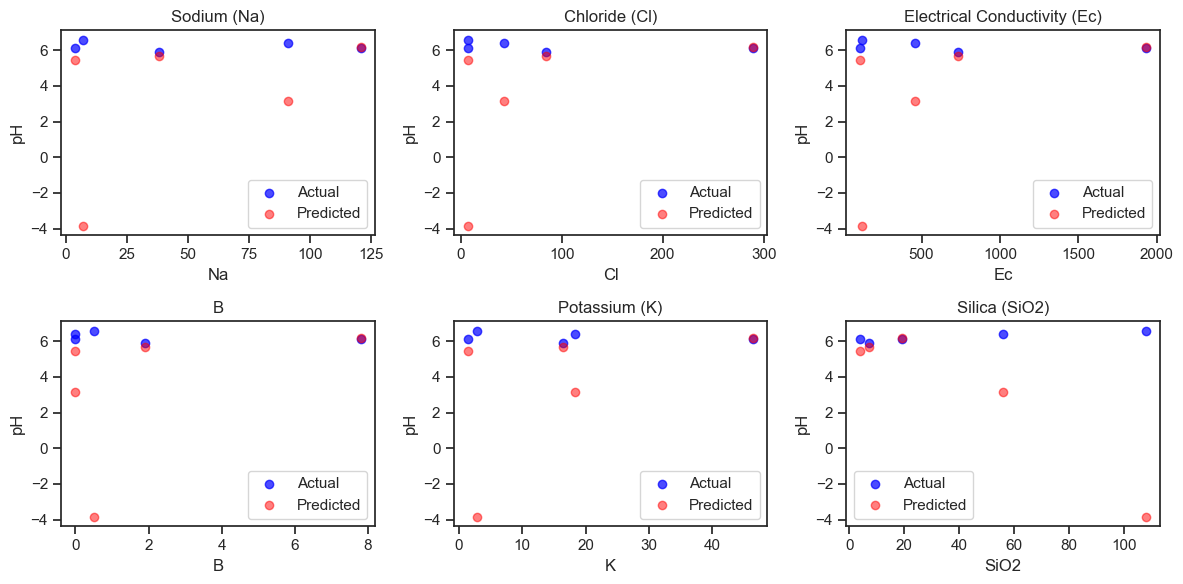

In [48]:
# Plot actual vs. predicted pH values with input features
plt.figure(figsize=(12, 6))

# Plot for the first input feature (Na)
plt.subplot(231)
plt.scatter(X_test['Na'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['Na'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Sodium (Na)')
plt.xlabel('Na')
plt.ylabel('pH')
plt.legend()

# Plot for Cl
plt.subplot(232)
plt.scatter(X_test['Cl'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['Cl'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Chloride (Cl)')
plt.xlabel('Cl')
plt.ylabel('pH')
plt.legend()

# Repeat for Ec
plt.subplot(233)
plt.scatter(X_test['Ec'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['Ec'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Electrical Conductivity (Ec)')
plt.xlabel('Ec')
plt.ylabel('pH')
plt.legend()

# Repeat for B
plt.subplot(234)
plt.scatter(X_test['B'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['B'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('B')
plt.xlabel('B')
plt.ylabel('pH')
plt.legend()

plt.subplot(235)
plt.scatter(X_test['K'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['K'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Potassium (K)')
plt.xlabel('K')
plt.ylabel('pH')
plt.legend()    

# Plot for SiO2
plt.subplot(236)
plt.scatter(X_test['SiO2'], y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(X_test['SiO2'], y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Silica (SiO2)')
plt.xlabel('SiO2')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Root Mean Squared Error (RMSE): 4.90
Mean Absolute Error (MAE): 2.93
R-squared (R2): -407.78


In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train the Gradient Boosting Regression model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_gb = gb_model.predict(X_test)

# Calculate RMSE, MAE, and R-squared for the Gradient Boosting model
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print evaluation metrics for the Gradient Boosting model
print("Gradient Boosting Regression Model:")
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_gb:.2f}")
print(f"R-squared (R2): {r2_gb:.2f}")

Gradient Boosting Regression Model:
Root Mean Squared Error (RMSE): 1.09
Mean Absolute Error (MAE): 0.88
R-squared (R2): -19.28


In [54]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Model:")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"R-squared (R2): {r2_xgb:.2f}")

XGBoost Regression Model:
Root Mean Squared Error (RMSE): 1.42
Mean Absolute Error (MAE): 1.18
R-squared (R2): -33.54


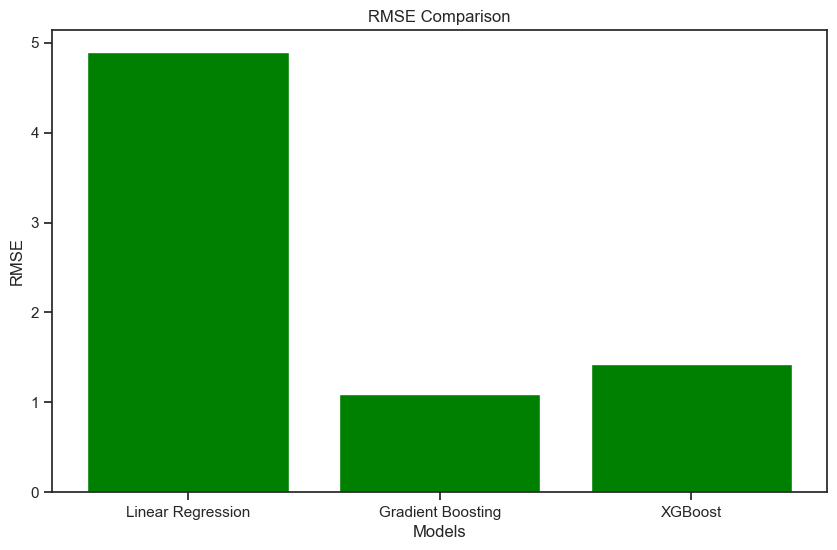

In [55]:
models = ['Linear Regression', 'Gradient Boosting', 'XGBoost']

rmse_values = [rmse, rmse_gb, rmse_xgb]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='green')
plt.title('RMSE Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

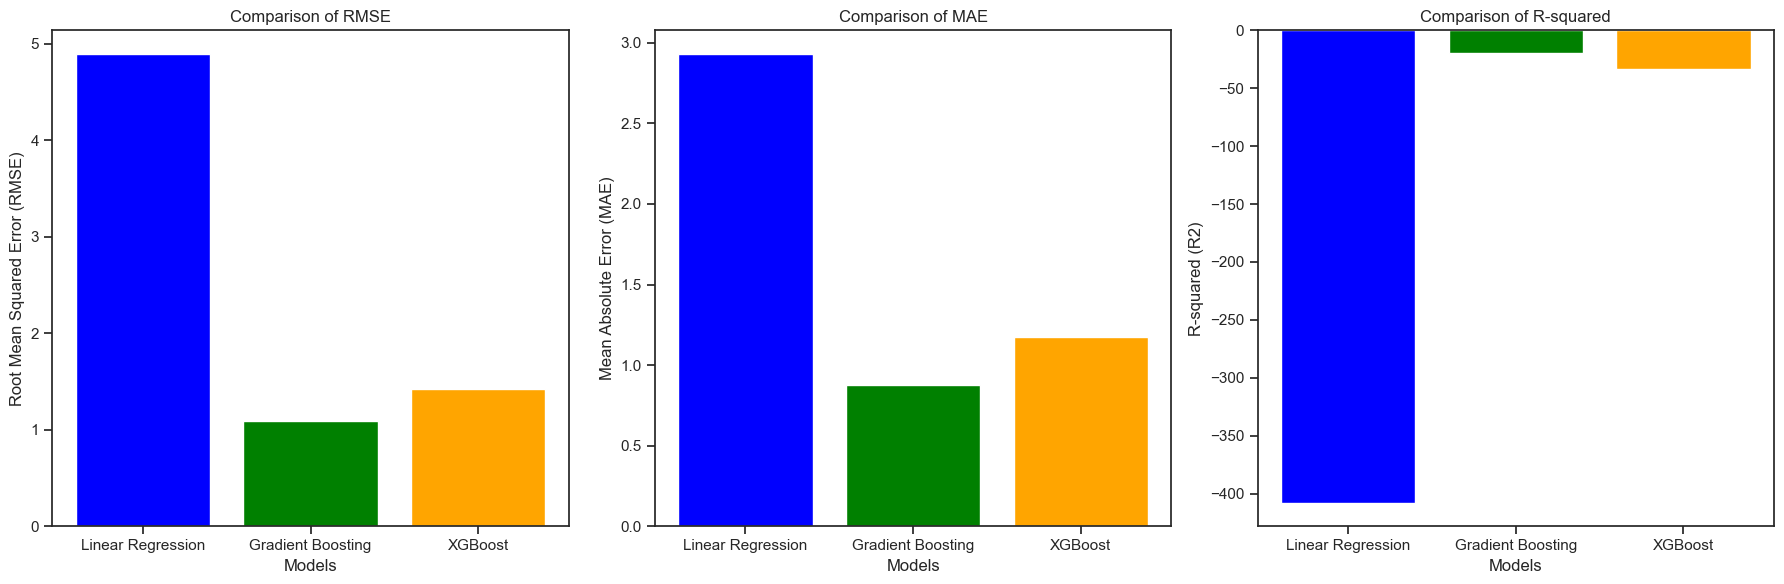

In [56]:
mae_values = [mae, mae_gb, mae_xgb]
r2_values = [r2, r2_gb, r2_xgb]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# RMSE comparison
axes[0].bar(models, rmse_values, color=['blue', 'green', 'orange'])
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_title('Comparison of RMSE')

# MAE comparison
axes[1].bar(models, mae_values, color=['blue', 'green', 'orange'])
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Mean Absolute Error (MAE)')
axes[1].set_title('Comparison of MAE')

# R-squared comparison
axes[2].bar(models, r2_values, color=['blue', 'green', 'orange'])
axes[2].set_xlabel('Models')
axes[2].set_ylabel('R-squared (R2)')
axes[2].set_title('Comparison of R-squared')

# Adjust layout
plt.tight_layout()
plt.show()

In [57]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define hyperparameters and search space
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params)
print(f"Best Model RMSE: {rmse_best:.2f}, MAE: {mae_best:.2f}, R-squared: {r2_best:.2f}")

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Model RMSE: 1.43, MAE: 1.19, R-squared: -33.88


In [58]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best_gb = best_model.predict(X_test)
rmse_best_gb = mean_squared_error(y_test, y_pred_best_gb, squared=False)
mae_best_gb = mean_absolute_error(y_test, y_pred_best_gb)
r2_best_gb = r2_score(y_test, y_pred_best_gb)

# Print best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params)
print(f"Best Model RMSE: {rmse_best_gb:.2f}, MAE: {mae_best_gb:.2f}, R-squared: {r2_best_gb:.2f}")

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Model RMSE: 1.11, MAE: 0.88, R-squared: -19.99
